# Part 2/2 - Preprocessing, Modelling & Selection
---

In this notebook, the subreddit posts will be cleaned, preprocessed, tokenized and modelled using various classifiers. It is broadly split up to 4 steps:


* **Step 1. Data Cleaning** - Imputing missing values, removal of duplicate posts. 


* **Step 2. Exploratory Data Analysis** - Preprocess of text data, word frequency 


* **Step 3: Modelling** - Creating benchmark model & candidate models for selection


* **Step 4: Selection & Insight** - Selection of best model, justification and further insights


* **Step5: Conclusion & Future Work**



## Housekeeping

Importing the libraries needed and reuseable functions that will be deployed extensively in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

import warnings
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

In [3]:
 def preprocess(sentence):
    '''

    Takes input of a document, converts to lowercase and removes special symbols, numbers and web addresses. 
    Tokenizes and lemmatizeswords using nltk methods to ready documents for vectorization

    '''
    
    sentence=str(sentence)
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    rem_keywords = re.sub(r'daily|thread|monday|tuesday|wednesday|thursday|friday|saturday|sunday|soccer'
                          r'football|bet|betting|betted','',rem_num)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_keywords)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    stem_words = [stemmer.stem(w) for w in lemma_words]
    
    return ' '.join(stem_words)

In [4]:
subreddit = pd.read_csv('.../datasets/subreddit.csv')
display(subreddit.head())
display(subreddit.shape)

# renaming the target column to avoid confusion with the subreddit word token later on
subreddit.rename(columns={'subreddit':'y_subreddit'}, inplace=True)

,subreddit,selftext,title
0,football,How many other current footballers (age 19 to ...,"Alex Ferguson said ""Give me Zidane and 10 piec..."
1,football,NaN,let me present the worst rating system in foot...
2,football,I want to inspire myself. I would prefer answe...,Who are some footballers with a great hard wor...
3,football,[removed],Who are some players with the best mentalities...
4,football,[removed],African Cup of Nation 2022 kicked off in Camer...


(4000, 3)

## Step 1: Data Cleaning (Removed/Deleted Posts, Missing Values & Duplicates)
---
### Removed/Deleted Posts


There is quite number of removed and deleted posts (1230 posts in total (~30% of posts)). There may be many reasons for removing or deleting a post (eg.inactive posts, irrelevant posts, offensive posts etc), unlike the approach taken to impute the `title` content into the `selftext`, the moderators of the subreddits made the conscious decision to remove/delete these posts, and therefore be excluded from the analysis.


In addition, the analysis is limited to 1000+ posts each from each subreddit to minimize model training time. There will still be ~2700 posts left for analysis, which is sufficient.


A new dataframe `df` is created by subsetting the posts that were not removed/deleted. `df` will be used henceforth.

In [5]:
display(subreddit[((subreddit["selftext"]=='[deleted]') | (subreddit['selftext']=='[removed]'))])

df = subreddit[~((subreddit["selftext"]=='[deleted]') | (subreddit['selftext']=='[removed]'))]

,y_subreddit,selftext,title
3,football,[removed],Who are some players with the best mentalities...
4,football,[removed],African Cup of Nation 2022 kicked off in Camer...
5,football,[removed],African Cup of Nation 2022 kicked off in Camer...
12,football,[removed],Is there a football that pros prefer to play w...
19,football,[removed],Anyone not happy about the winter world cup?
...,...,...,...
3987,SoccerBetting,[removed],Beginner
3988,SoccerBetting,[removed],Congratulations to those that believed in me a...
3989,SoccerBetting,[removed],Potd
3996,SoccerBetting,[removed],Juventus vs Inter Milan Predictions and Bettin...


### Missing Values
There are **1308** null values in the column of interest (the `selftext` column). It is observed that it is fairly common for reddit users to simply post what they wish to say all in the title instead of using the `title` field and inserting their content as a `selftext`.There is also a very low possibility of a data collection error made while using the PushShift API, thus the content in `title` will be imputed in place of the null values in `selftext`.

As mentioned above, important information regarding the subject of discussion in the subreddit is also present in the `title`and should be included in the analysis. To address the missing values as well as improving the analysis, the content in the entire `title` column will be appended to `selftext`

In [6]:
# replacing null values with titles
display(df.isnull().sum())
df['selftext'] = df['title'] + df['selftext']
df['selftext'].fillna(df['title'],inplace=True)

y_subreddit       0
selftext       1308
title             0
dtype: int64

### Duplicated Posts

In [7]:
display(df[df['selftext'].duplicated()])
df.drop_duplicates(subset=['selftext'],inplace=True)

,y_subreddit,selftext,title
71,football,r/Football Daily Discussion ThreadSmall talk o...,r/Football Daily Discussion Thread
103,football,r/Football Daily Discussion ThreadSmall talk o...,r/Football Daily Discussion Thread
149,football,r/Football Daily Discussion ThreadSmall talk o...,r/Football Daily Discussion Thread
209,football,r/Football Daily Discussion ThreadSmall talk o...,r/Football Daily Discussion Thread
246,football,r/Football Daily Discussion ThreadSmall talk o...,r/Football Daily Discussion Thread
...,...,...,...
2343,SoccerBetting,btts ht and last second goal bugsGreetings guy...,btts ht and last second goal bugs
3018,SoccerBetting,Daily Picks Thread Saturday - 28/08/21,Daily Picks Thread Saturday - 28/08/21
3558,SoccerBetting,France vs HungaryPutting a bet on France winni...,France vs Hungary
3658,SoccerBetting,Daily Picks Thread - Saturday 12/06/21,Daily Picks Thread - Saturday 12/06/21


In [8]:
df.reset_index(drop=True, inplace=True)

In [91]:
df.shape

(2706, 5)

## Step 2: Exploratory Data Analysis
---
Once the data is clean, a preprocessing function will be passed into the `selftext` column to ensure that it is in the correct format for vectorization. Specifically, the function will perform the following with the help of the `nltk` library:


1. Converts document to lowercase
2. Removes numbers, symbols and web addresses (starting with http) & unhelpful keywords\**
3. Tokenizes document
4. Stems and lemmatizes document
5. Returns a string to be stored in the dataframe


Following that, the target column (`y_subreddit`) will be encoded.
>* '1': Positive Class (Post belongs to r/Football)
>* '0': Negative Class (Post belongs to r/Soccerbetting)




\**   The tokens 'daily', 'thread' and 'monday' - 'sunday' were removed from the corpus because r/Soccerbetting has a dedicated posts daily titled 'Daily Picks Thread \<Weekday> \<Date>' which does not provide useful insight to generalize to normal posts by users.

\** Common occuring words such as 'soccer','football' and 'betting' were also removed as these words were commonly occurring and would dilute the effect of other words on the model.

In [9]:
df['clean_text']=df['selftext'].map(lambda s:preprocess(s))
df['y_subreddit'] = df['y_subreddit'].apply(lambda x: 1 if x=='football' else 0)

There is a slight class imbalance of 57-43 in favour of the positive class (shown in the cell below). This is the baseline score we will have to meet.


This is the baseline score as it is the score for the negative & positive classes if we created a model that simply predicted all future posts to be either in the positive or negative class and obtain an accuracy score of 57% and 43% respectively. 

In [10]:
display(df['y_subreddit'].value_counts(normalize=True))

1    0.56578
0    0.43422
Name: y_subreddit, dtype: float64

### Word Lengths

The distribution of words in the data is right skewed as seen from the plot below. It is a right skewed distribution with a majority of posts below 30 words in length. 

The distribution of word lengths of the negative and positive classes are similar with similar mean and median values.

The positive class has a mean word length of 29.57 and median of 10.0
The negative class has a mean word length of 23.87 and median of 13.0


count    2706.000000
mean       27.090909
std        49.774499
min         1.000000
25%         5.000000
50%        11.000000
75%        27.000000
max       839.000000
Name: word_length, dtype: float64

Text(0, 0.5, 'Count')

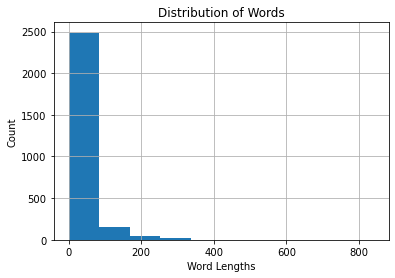

In [60]:
df['word_length'] = df['clean_text'].apply(lambda x:len(x.split(' ')))
avg_positive_length = round(df[df['y_subreddit']==1]['word_length'].mean(),2)
avg_negative_length = round(df[df['y_subreddit']==0]['word_length'].mean(),2)
med_positive_length = df[df['y_subreddit']==1]['word_length'].median()
med_negative_length = df[df['y_subreddit']==0]['word_length'].median()
print(f'The positive class has a mean word length of {avg_positive_length} and median of {med_positive_length}')
print(f'The negative class has a mean word length of {avg_negative_length} and median of {med_negative_length}')
display(df['word_length'].describe())
df['word_length'].hist()
plt.title('Distribution of Words')
plt.xlabel('Word Lengths')
plt.ylabel('Count')

### Most Frequently Occuring Words in r/Football & r/Soccerbetting

In [11]:
cvec = CountVectorizer()

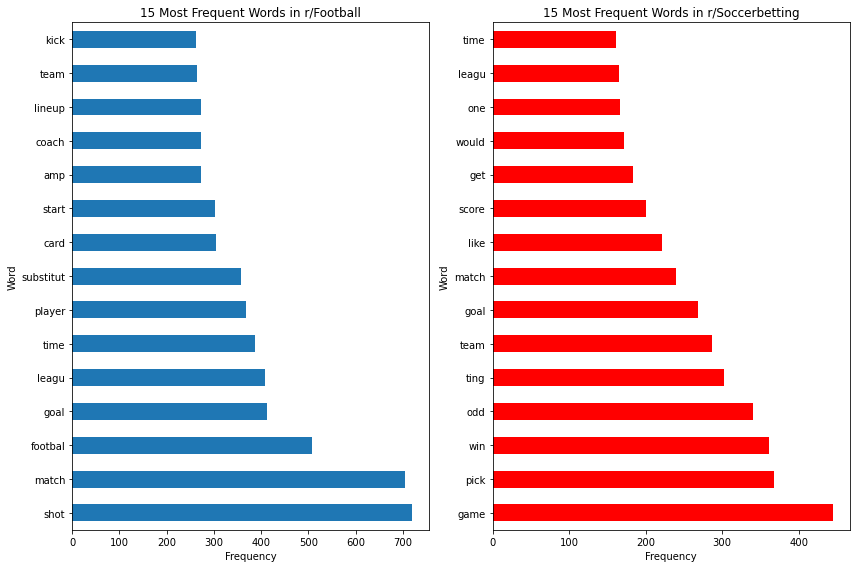

In [12]:
# convert training data to dataframe
cvec_df = pd.DataFrame(cvec.fit_transform(df['clean_text']).todense(), 
                          columns=cvec.get_feature_names())
cvec_df = pd.concat([cvec_df, df['y_subreddit']], axis='columns')

# # plot top 15 occuring words
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

cvec_df[cvec_df['y_subreddit']==1].drop(columns=['y_subreddit']).sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                                                                                 ax=axes[0])
axes[0].set_title('15 Most Frequent Words in r/Football')
axes[0].set_ylabel('Word')
axes[0].set_xlabel('Frequency')

cvec_df[cvec_df['y_subreddit']==0].drop(columns=['y_subreddit']).sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                                                                                 ax=axes[1],
                                                                                                                 color='r')
axes[1].set_title('15 Most Frequent Words in r/Soccerbetting')
axes[1].set_ylabel('Word')
axes[1].set_xlabel('Frequency')

plt.tight_layout()

From the frequency charts above, we can make the following observations:


* There are overlapping words in the top 15 most frequent words such as 'team', 'goal', 'match', 'league', 'time'. Overlapping words are expected as the subject matter of both subreddits are quite similar.


* Words strongly associated with betting such as 'odd', 'pick', 'game' and 'win' appear most commonly in the negative class. This is a reasonable observation.


* The frequent words of the positive class tend to be more holistic in nature around Football as it contains words like 'coach', 'player', 'lineup'and 'league' whereas the frequent words in the negative class tend to centre around the betting aspect of football with little mention of other related words.

### Most Frequent Occuring Bigrams and Trigrams

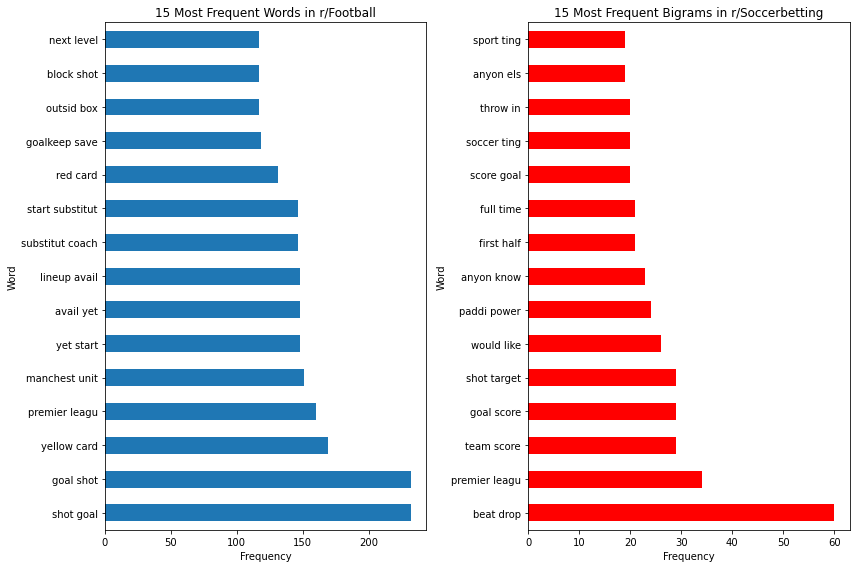

In [13]:
cvec_bigram = CountVectorizer(ngram_range=(2,2))

# convert training data to dataframe
cvec_bigram_df = pd.DataFrame(cvec_bigram.fit_transform(df['clean_text']).todense(), 
                          columns=cvec_bigram.get_feature_names())
cvec_bigram_df = pd.concat([cvec_bigram_df, df['y_subreddit']], axis='columns')

# # plot top 15 occuring words
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

cvec_bigram_df[cvec_bigram_df['y_subreddit']==1].drop(columns=['y_subreddit']).sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                                                                                 ax=axes[0])
axes[0].set_title('15 Most Frequent Words in r/Football')
axes[0].set_ylabel('Word')
axes[0].set_xlabel('Frequency')

cvec_bigram_df[cvec_bigram_df['y_subreddit']==0].drop(columns=['y_subreddit']).sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                                                                                 ax=axes[1],
                                                                                                                 color='r')
axes[1].set_title('15 Most Frequent Bigrams in r/Soccerbetting')
axes[1].set_ylabel('Word')
axes[1].set_xlabel('Frequency')

plt.tight_layout()

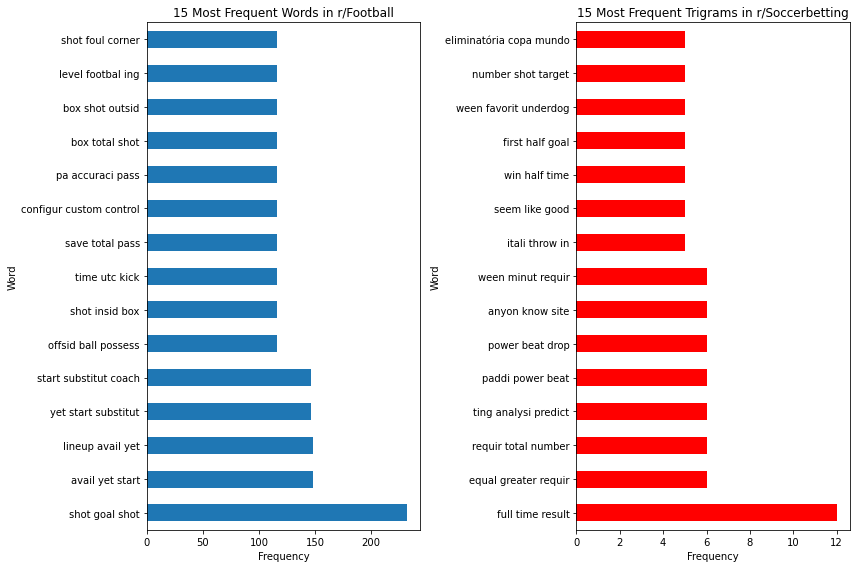

In [18]:
cvec_trigram = CountVectorizer(ngram_range=(3,3))

# convert training data to dataframe
cvec_trigram_df = pd.DataFrame(cvec_trigram.fit_transform(df['clean_text']).todense(), 
                          columns=cvec_trigram.get_feature_names())
cvec_trigram_df = pd.concat([cvec_trigram_df, df['y_subreddit']], axis='columns')

# # plot top 15 occuring words
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

cvec_trigram_df[cvec_trigram_df['y_subreddit']==1].drop(columns=['y_subreddit']).sum().sort_values(ascending=False).head(15).plot(kind='barh',
                                                                                                                                  ax=axes[0])
axes[0].set_title('15 Most Frequent Words in r/Football')
axes[0].set_ylabel('Word')
axes[0].set_xlabel('Frequency')

cvec_trigram_df[cvec_trigram_df['y_subreddit']==0].drop(columns=['y_subreddit']).sum().sort_values(ascending=False).head(15).plot(kind='barh', 
                                                                                                                                  ax=axes[1], 
                                                                                                                                  color='r')
axes[1].set_title('15 Most Frequent Trigrams in r/Soccerbetting')
axes[1].set_ylabel('Word')
axes[1].set_xlabel('Frequency')

plt.tight_layout()

## Step 3: Modelling
---

In this step, 4 models including 1 benchmark will be ran. The models are:


- Logistic Regression/Count Vectorization (Benchmark Model)
- K Neighbors/TF-IDF Vectorization with Hyperparameter Tuning
- Multinomial Naive Bayes/TF-IDF Vectorization with Hyperparameter Tuning
- Random Forest/TF-IDF Vectorization with Hyperparameter Tuning

For the benchmark model, a Logistic Regression (with default hyperparameters) will be used following Count Vectorization of the corpus. This is chosen for the benchmark because of its simplicity and speed of modelling. 

The other models will be vectorized with the TF-IDF Vectorizer which is built on top of the Count Vectorizer and assigns importance to certain words by creating a normalized count where each word count is divided by the number of documents this word appears in. Other estimators will also be used in conjunction with TF-IDF.

#### Performance Metric
Recall that our business problem requires the model to correctly identify posts pertaining to soccer betting (the negative class) the selected model must be able to achieve a performance metric of < 90% accuracy while optimizing for **Specificity**.


**Specificity** has to be maximized as False Positives would mean that posts that are supposed to be about betting would be retained on r/Football, hence False Positives have to be reduced to as low as practically possible. On the other hand, False Negatives do not pose as much of an issue to the business problem as it means that the model is being overly cautious to misclassify non-soccer betting posts as such. Therefore, a trade-off with recall is acceptable.

### Defining Features, Target and Train-Test Split

In [19]:
X = df['clean_text']
y = df['y_subreddit']

# Random state for reproducibility
seed = 42

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=seed)

#### Reuseable Function to produce the classification metrics required

In [21]:
def metrics(fitted_estimator, X_train=X_train, X_test=X_test, 
                           y_train=y_train, y_test=y_test, gridsearch=False, ):
    '''

    Takes input of a fitted estimator and outputs the various classification metrics. if the fitted model is a gridsearch
    It will also output the best params_ and best_score_.

    '''
    pred = fitted_estimator.predict(X_test)
    pred_proba = fitted_estimator.predict_proba(X_test)[:,1]
    tn,fp,fn,tp = confusion_matrix(y_test, pred).ravel()
    recall = round(tp/(tp+fn),3)
    precision = round(tp/(tp+fp),3)
    specificity = round(tn/(tn+fp),3)
    f1 = round(f1_score(y_test, pred),3)
    training_score = round(fitted_estimator.score(X_train, y_train),3)
    testing_score = round(fitted_estimator.score(X_test, y_test),3)
    auc_score = round(roc_auc_score(y_test,pred_proba),3)

    display(ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels = ['Soccerbetting', 'football']))
    
    if gridsearch:
        display(f'Best Params:  {fitted_estimator.best_params_}')
        display(f'Best Score:   {round(fitted_estimator.best_score_,3)}')
        
    display(f'The training score is: {training_score}.')
    display(f'The testing score is {testing_score}.')
    display(f'The specificity score is {specificity}.')
    display(f'The recall score is {recall}.')
    display(f'The precision score is {precision}.')
    display(f'The f1 score is {f1}.')
    display(f'The AUC score is {auc_score}.')
    
    return training_score, testing_score , specificity, recall, precision, f1, auc_score

In [22]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(2029,)

(2029,)

(677,)

(677,)

### Benchmark Model Logistic Regression/ Count Vectorizer

'The training score is: 0.989.'

'The testing score is 0.894.'

'The specificity score is 0.816.'

'The recall score is 0.953.'

'The precision score is 0.871.'

'The f1 score is 0.91.'

'The AUC score is 0.96.'

Time taken: 0.168s.


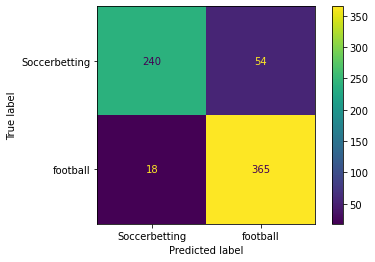

In [23]:
t0=time()

cvec = CountVectorizer()

bench = Pipeline([
    ('cvec',cvec),
    ('logreg', LogisticRegression())
])

bench.fit(X_train, y_train)
duration = round(time()-t0,3)
bench_train, bench_test, bench_specificity, bench_recall, bench_precision, bench_f1, bench_auc = metrics(bench)
print(f'Time taken: {duration}s.')

# creating a dictionary to consolidate all model scores to convert into a DataFrame later on
results = {'model':['Logistic Regression/CVEC'],
           'training_score':[bench_train],
          'testing_score':[bench_test],
           'specificity':[bench_specificity],
          'recall':[bench_recall],
          'precision':[bench_precision],
          'f1':[bench_f1],
           'AUC_score':[bench_auc],
          'time_taken(/s)':[duration]}

### K Neighbors/ TF-IDF Vectorizer

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


"Best Params:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__p': 'uniform', 'tvec__max_features': 8000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}"

'Best Score:   0.887'

'The training score is: 0.916.'

'The testing score is 0.897.'

'The specificity score is 0.823.'

'The recall score is 0.953.'

'The precision score is 0.875.'

'The f1 score is 0.913.'

'The AUC score is 0.952.'

Time taken: 203.21s.


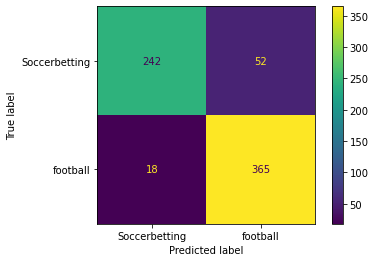

In [24]:
t0 = time()

tvec = TfidfVectorizer()
pipe1 = Pipeline([
    ('tvec',tvec),
    ('knn', KNeighborsClassifier())
])

pipe1_params = {
    'tvec__min_df':[0.1,0.25,1],
    'tvec__max_features':[3000,8000,12000],
    'tvec__stop_words':['english', None],
    'tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'knn__metric':['euclidean','manhattan','minkowski'],
    'knn__n_neighbors':[1,15,35],
    'knn__p':['uniform', 'distance']
}

gs1 = GridSearchCV(pipe1, pipe1_params, cv=5, n_jobs=3, verbose=1)
gs1.fit(X_train, y_train)
duration = round(time()-t0,3)
gs1_train, gs1_test, gs1_specificity, gs1_recall, gs1_precision, gs1_f1, gs1_auc = metrics(gs1,gridsearch=True)

print(f'Time taken: {duration}s.')

results['model'].append('KNN Classifier/TVEC')
results['training_score'].append(gs1_train)
results['testing_score'].append(gs1_test)
results['specificity'].append(gs1_specificity)
results['recall'].append(gs1_recall)
results['precision'].append(gs1_precision)
results['f1'].append(gs1_f1)
results['AUC_score'].append(gs1_auc)
results['time_taken(/s)'].append(duration)

### Multinomial Naive Bayes/ TF-IDF Vectorizer

Fitting 5 folds for each of 54 candidates, totalling 270 fits


"Best Params:  {'tvec__max_features': 8000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}"

'Best Score:   0.918'

'The training score is: 0.972.'

'The testing score is 0.913.'

'The specificity score is 0.867.'

'The recall score is 0.948.'

'The precision score is 0.903.'

'The f1 score is 0.925.'

'The AUC score is 0.966.'

Time taken: 9.754s.


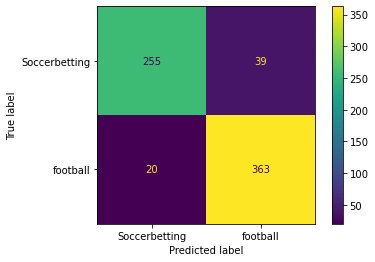

In [25]:
t0=time()
pipe2 = Pipeline([
    ('tvec',tvec),
    ('nb', MultinomialNB())
])

pipe2_params = {
    'tvec__min_df':[0.1,0.25,1],
    'tvec__max_features':[4000,8000,10000],
    'tvec__stop_words':['english', None],
    'tvec__ngram_range':[(1,1), (1,2), (1,3)]
}

gs2 = GridSearchCV(pipe2, pipe2_params, cv=5, n_jobs=3, verbose=1)
gs2.fit(X_train, y_train)
duration = round(time()-t0,3)
gs2_train, gs2_test, gs2_specificity, gs2_recall, gs2_precision, gs2_f1, gs2_auc = metrics(gs2, gridsearch=True)
print(f'Time taken: {duration}s.')

results['model'].append('Multinomial NB/TVEC')
results['training_score'].append(gs2_train)
results['testing_score'].append(gs2_test)
results['specificity'].append(gs2_specificity)
results['recall'].append(gs2_recall)
results['precision'].append(gs2_precision)
results['f1'].append(gs2_f1)
results['AUC_score'].append(gs2_auc)
results['time_taken(/s)'].append(duration)

### Random Forest/ TF-IDF Classifier

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


"Best Params:  {'rf__max_depth': None, 'rf__max_samples': None, 'rf__n_estimators': 100, 'tvec__max_features': 8000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}"

'Best Score:   0.916'

'The training score is: 1.0.'

'The testing score is 0.897.'

'The specificity score is 0.806.'

'The recall score is 0.966.'

'The precision score is 0.867.'

'The f1 score is 0.914.'

'The AUC score is 0.957.'

Time taken: 318.44s.


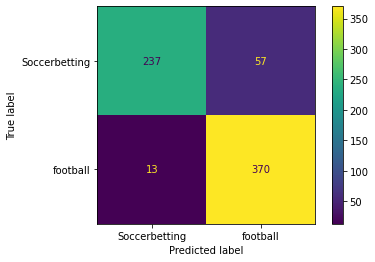

In [26]:
t0=time()
pipe3 = Pipeline([
    ('tvec',tvec),
    ('rf', RandomForestClassifier(random_state=seed))
])

pipe3_params = {
    'tvec__min_df':[0.1,0.25,1],
    'tvec__max_features':[5000,8000,12000],
    'tvec__stop_words':['english', None],
    'tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'rf__n_estimators':[80,100],
    'rf__max_samples':[None,0.1,0.3],
    'rf__max_depth':[None,25,50]
}

gs3 = GridSearchCV(pipe3, pipe3_params, cv=5, n_jobs=3, verbose=1)
gs3.fit(X_train, y_train)
duration = round(time()-t0,3)
gs3_train, gs3_test, gs3_specificity, gs3_recall, gs3_precision, gs3_f1, gs3_auc = metrics(gs3,gridsearch=True)
print(f'Time taken: {duration}s.')

results['model'].append('Random Forest Classifier/TVEC')
results['training_score'].append(gs3_train)
results['testing_score'].append(gs3_test)
results['specificity'].append(gs3_specificity)
results['recall'].append(gs3_recall)
results['precision'].append(gs3_precision)
results['f1'].append(gs3_f1)
results['AUC_score'].append(gs3_auc)
results['time_taken(/s)'].append(duration)

### Step 4: Selection & Insights

#### Model Selection

The best model is the **Multinomial NB/TVEC** (Index number 2 in DataFrame below) as it offered the highest accuracy on the test test, as well as the highest specificity and AUC score among all the other classifiers.

In [27]:
comparison = pd.DataFrame(results)
display(comparison)

,model,training_score,testing_score,specificity,recall,precision,f1,AUC_score,time_taken(/s)
0,Logistic Regression/CVEC,0.989,0.894,0.816,0.953,0.871,0.910,0.960,0.168
1,KNN Classifier/TVEC,0.916,0.897,0.823,0.953,0.875,0.913,0.952,203.210
2,Multinomial NB/TVEC,0.972,0.913,0.867,0.948,0.903,0.925,0.966,9.754
3,Random Forest Classifier/TVEC,1.000,0.897,0.806,0.966,0.867,0.914,0.957,318.440


> The winner is......**Multinomial NB/TVEC** with the following defined parameters, other parameters were kept at default:
>* 'tvec__max_features': 8000 
>* 'tvec__min_df': 1 
>* 'tvec__ngram_range': (1, 1)
>* 'tvec__stop_words': None


There are about 5.8% of posts that were False Positives.

In [90]:
# Examination of False Positives (true value r/Soccerbetting but predicted r/Football)
fp = X_test[gs2.predict(X_test)>y_test]
misclassified = pd.DataFrame(fp)
print(f'There are {len(misclassified)}/{len(y_test)}({round(100*(len(misclassified)/len(y_test)),2)}%)' 
      f' misclassified posts in the test set.\n')

There are 39/677(5.76%) misclassified posts in the test set.



#### Comparison with Benchmark (Logistic Regression/ Count Vectorization)


For the Multinomial NB classifier, each probability of each feature given that it is in positive/negative class is computed by the model. If a feature has a high probability in the negative class and lower in the other, it means that it has a greater discriminative power for documents that belong in the negative class, and vice versa. This can be computed by obtaining the differences in class probabilities of each feature. We use log probabilities for easier visual representation.


A similar measure for the benchmark Logistic Regression Model would be obtaining the feature coefficients as it will inform on the strongest components that contributes to the model.

**Observations**


* In the figure below, the top 15 contributors for each model is shown and it can be observed that about 60% of the features are common, which is expected. This is why the performance metrics are very close.


* In fact, the top 3 contributors for both models are identical. We can infer that the tokens:`pick`, `bet` & `odd` are the most important contributors to the model.

There are 9 common tokens in the top 15 tokens (60.0%).They are ['pick', 'ting', 'odd', 'beat', 'barcelona', 'profit', 'site', 'drop', 'btt'].


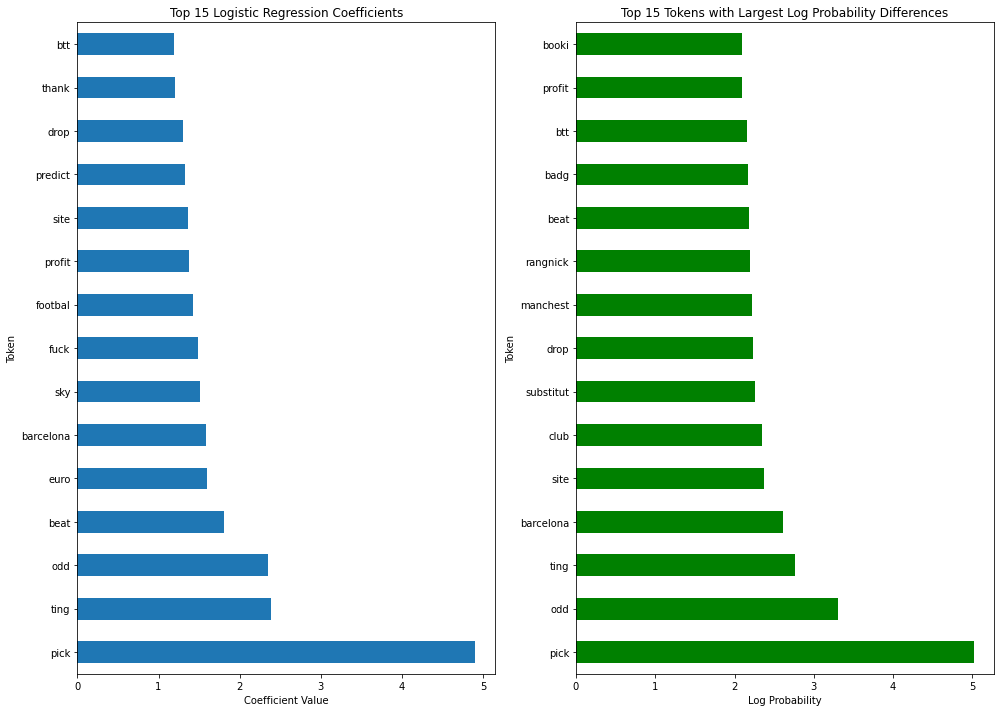

In [29]:
# Extracting top 15 coefficients for barh plot
lr_coef = bench[1].coef_.reshape(-1).tolist()
lr_feature_names = bench[0].get_feature_names()
benchmark = pd.DataFrame({'coefficients':lr_coef,'tokens':lr_feature_names}).set_index('tokens')
benchmark['abs_coefs'] = benchmark['coefficients'].apply(np.abs)

# Extracting top 15 log proba differences for barh plot
betting_log_proba = gs2.best_estimator_[1].feature_log_prob_[0,:]
soccer_log_proba = gs2.best_estimator_[1].feature_log_prob_[1,:]
feature_names = gs2.best_estimator_[0].get_feature_names()
evaluate = pd.DataFrame({'r/Soccerbetting':betting_log_proba, 'r/Football':soccer_log_proba, 
                        'tokens':feature_names}).set_index('tokens')
evaluate['log_proba_difference'] = np.abs(evaluate['r/Soccerbetting']-evaluate['r/Football'])

# Extracting common tokens
identical_tokens = [w for w in benchmark['abs_coefs'].sort_values(ascending=False).head(15).index if
                   w in evaluate['log_proba_difference'].sort_values(ascending=False).head(15).index]
print(f'There are {len(identical_tokens)} common tokens in the top 15 tokens ({round(100*(len(identical_tokens)/15),2)}%).'
      f'They are {identical_tokens}.')

# Plotting information extracted above
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))

benchmark['abs_coefs'].sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0])                                                                                                    
ax[0].set_title('Top 15 Logistic Regression Coefficients')
ax[0].set_ylabel('Token')
ax[0].set_xlabel('Coefficient Value')

evaluate['log_proba_difference'].sort_values(ascending=False).head(15).plot(kind='barh',ax=ax[1], color='g')                                                                                           
ax[1].set_title('Top 15 Tokens with Largest Log Probability Differences')
ax[1].set_ylabel('Token')
ax[1].set_xlabel('Log Probability')

plt.tight_layout()

## Step 5: Conclusion & Future Work


In summary, the data was obtained by utilizing the PushShift API to obtain the most recent 2000 posts (as of time of project) from each subreddit to provide the dataset for the classification model so that it can be trained to classify future posts into either r/Football or r/Soccerbetting.


After cleaning and preprocessing the data, several models were fitted and compared to the benchmark model. Using the desired performance metric (accuracy and specificity), the **Multinomial Naive Bayes/TF-IDF Classifier** provided the best results on the test data and was selected as the classifier of choice for production as part of the moderator tools to ensure that gambling content is policed in the r/Football subreddit.


### Suggested Improvements


* **Increase Model Vocabulary**: Instead of simply obtaining data from the r/Soccerbetting subreddit, data can be obtained from other subreddits which centre on gambling in general (such as [r/Gambling](https://www.reddit.com/r/gambling/), this will increase the model's ability to generalize when exposed to more generic words associated with gambling.


* **Improve Data Quality**: One of the likely reasons for misclassification is typo errors from the user, improvements can be done on the text preprocessing function that takes common spelling errors into account prior to modelling. An example would be to use the `TextBlob` library with the `Word` module. Rectifying spelling mistakes will enable improve lemmatization and stemming performance, which will likely contribute to improvements in model performance.